# Reshaping Exercises

Before diving into actually doing some exercises, a few notes about reshaping in `pandas`. 

**So many tools:** As is so often the case with `pandas`, when there are multiple ways that something can be done, `pandas` implements all of them, even it if results in a lot of duplication of funcationality. As a result, there are several sets of methods that do very similar things, and which can be hard to keep straights: 

- `melt` and `pivot`: Tools for moving a dataset from long-to-wide (`pivot`) or wide-to-long (`melt`).
- `pivot_table`: Like `pivot`, but allows you to do aggregations during the reshape if you want.
- `stack` and `unstack`: Like `melt` and `pivot`, but only for use when your variables are stored in indices. I don't use these much. 

Personally, **I find melt and pivot most useful.** `pivot_table` *can* do aggregations during the reshape, but you can always do aggregations yourself using `groupby`. :) 

Also, I have to go look at [these pictures](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html)... every time I reshape. Don't hesistate to look them up for help!

**What SHOULD I want my data to look like?** Just a reminder that a natural question to ask is "in what format should I want my data?" Obviously this question is subjective, but as you read in the Hadley Wickham [piece I assigned](http://vita.had.co.nz/papers/tidy-data.html), this is a good standard definition for a "tidy" dataset to which we might aspire: 

1. Each variable forms a column.
2. Each observation forms a row.
3. Each type of observational unit forms a table.

In general, I'm a big fan of this approach, and I think it's a good one to use (especially numbers 1 and 2).

Note that the question of what forms an "observation" depends on the analysis you plan to run (which depends on the answer you seek to ask! See! EVERYTHING ALWAYS COMES BACK TO THE QUESTION YOU ARE SEEKING TO ANSWER!). Suppose you have data on GDP from different countries for many years. If you plan to run a panel analysis where each observation is a country-year, then each row should be a country-year. But if you plan to do a country-level analysis using measures of, say, GDP variation over time, then each row should be a country!



## Exercises!

So in this exercise, we're going to work with data from the World Development Indicators. Unlike in previous exercises, however, where I cleaned up the data before giving it to you, we'll be working with the raw data just as you would get it from the World Bank download site. 


## Gradescope Autograding

Please follow [all standard guidance](https://www.practicaldatascience.org/html/autograder_guidelines.html) for submitting this assignment to the Gradescope autograder, including storing your solutions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.

For this assignment, please name your file `exercise_reshaping.ipynb` before uploading.

You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex2_num_rows",
    "ex4_num_rows",
    "ex5_num_countries",
    "ex6_relationship",
    "ex7_relationship",
    "ex8_countries_in_panel",
    "ex10_demeaned_corr",
}
```


### Submission Limits

Please remember that you are **only allowed three submissions to the autograder.** Your last submission (if you submit 3 or fewer times), or your third submission (if you submit more than 3 times) will determine your grade Submissions that error out will **not** count against this total.

### Exercise 1

Import the data using a link from [here](https://github.com/nickeubank/MIDS_Data/blob/master/World_Development_Indicators/raw_WDI_Data_csv.zip) and load it into pandas without unzipping it (did you know pandas will read zip files directly?!).

In [49]:
import pandas as pd
import urllib.request
from io import BytesIO
from zipfile import ZipFile

url = "https://github.com/nickeubank/MIDS_Data/raw/master/World_Development_Indicators/raw_WDI_Data_csv.zip"

df = pd.read_csv(url, compression="zip")

pd.set_option("mode.copy_on_write", True)

### Exercise 2

In this exercise, we'd like to look at the relationship between GDP and inequality across countries. So before anything else, thin down your dataset by getting only the rows related to:

- GDP per capita (in Constant US Dollars -- the "constant" means values are have been adjusted for inflation, so values from 1970 can be directly compared with 2010)
- Gini coefficient
- Information on income shares (what percentage of total income goes to X% of the income distribution). **There are 7 of these in total.**

Store the number of rows you get from this updated dataset in `"ex2_num_rows"`.

**NOTE:** this is non-trivial. This is a big dataset with LOTS of variables, so you'll have to use your data wrangling skills to see all the variables names. Remember that if you want to see all the entries in something but python compresses it (so it doesn't take up too much space), you can loop over it and print each item separately to make it show everything!

**NOTE 2:** If you _do_ print out all the variable names, please comment out the code before you submit your notebook so graders don't end up swimming in print-outs. 

In [4]:
unique_indicators = df["Indicator Name"].unique()
gdp_indicator = "GDP per capita (constant 2010 US$)"
gini_indicator = "GINI index (World Bank estimate)"
gdp_rows = df[df["Indicator Name"] == gdp_indicator]
gini_rows = df[df["Indicator Name"] == gini_indicator]

In [5]:
income_share_indicators = [
    indicator for indicator in unique_indicators if "income share" in indicator.lower()
]

In [48]:
income_share_rows = pd.DataFrame()

for indicator in income_share_indicators:
    income_share_rows = pd.concat(
        [income_share_rows, df[df["Indicator Name"].str.contains(indicator, na=False)]]
    )

final_rows = pd.concat([gdp_rows, gini_rows, income_share_rows])

In [7]:
final_rows.shape[0]

2376

In [8]:
ex2_num_rows = final_rows.shape[0]

### Exercise 3

OK, that makes our data a lot more manageable, but it's still pretty heinous.

In our analysis, we know that we'll want to have country-years as our units of observation, so let's start reshaping. Come up with a strategy that gets our inequality variables as columns, and makes each of our future observations (i.e. each country-year) a row. 

*Hint:* It can sometimes be helpful to drop useless columns before a reshape.

*Other hint:* Sometimes you will end up with your column names stored in a hierarchical (multi-level) `.column` object structure. As with hierarchical indices for rows, they’re a pain. (Whether this occurs depends on the exact syntax you use, so you may or may not get it).

The two easy ways to fix these hierarchical `.column` objects are:

- Just drop a level: df.columns.drop_level(0)` where 0 is which level you want to drop.
- Directly manipulate the column names by doing something to the df.columns object and re-assigning to df.columns. For example, you can just concatenate two columns levels (they're stored as tuples) with a dash between them with `df.columns = map(lambda x: str(x[0]) + "-" + str(x[1]), df.columns)`.

In [9]:
final_rows.drop(["Indicator Code", "Unnamed: 63", "Country Code"], axis=1, inplace=True)

In [11]:
df_melted = final_rows.melt(
    id_vars=["Country Name", "Indicator Name"], var_name="Year", value_name="Value"
)

In [13]:
df_pivoted = df_melted.pivot(
    index=["Country Name", "Year"], columns="Indicator Name", values="Value"
).reset_index()

### Exercise 4

Now that you've done your reshapes, subset for observations that are post-1980. Store the number of rows in your reshaped data with only data from the years after 1980 in `"ex4_num_rows"`.

In [47]:
df_pivoted["Year"] = pd.to_numeric(df_pivoted["Year"])
df_post_1980 = df_pivoted[df_pivoted["Year"] > 1980]

In [17]:
df_post_1980.shape[0]

10032

In [19]:
ex4_num_rows = df_post_1980.shape[0]

### Exercise 5

Subset for observations for which we have GINI index estimates. How many unique *countries* do you end up with? Store this answer in `ex5_num_countries`.

In [20]:
df_post_1980_gini_present = df_post_1980[
    df_post_1980["GINI index (World Bank estimate)"].notnull()
].reset_index(drop=True)

In [21]:
df_post_1980_gini_present["Country Name"].nunique()

164

In [22]:
ex5_num_countries = df_post_1980_gini_present["Country Name"].nunique()

### Exercise 6

Plot the relationship between **log** GDP per capita and Gini scores for all country years and add a linear fit as well. Is higher inequality associated with higher log GDP? Store your answer (as `"yes"` or `"no"`) in `results` under the key `"ex6_relationship"`.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

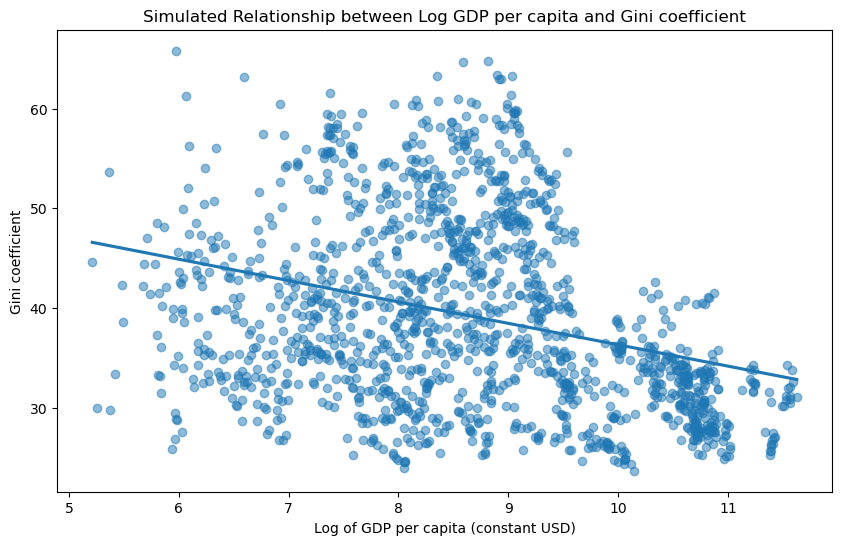

In [25]:
df_post_1980_gini_present["log GDP per capita"] = np.log(
    df_post_1980_gini_present["GDP per capita (constant 2010 US$)"]
)

plt.figure(figsize=(10, 6))
sns.regplot(
    x="log GDP per capita",
    y="GINI index (World Bank estimate)",
    data=df_post_1980_gini_present,
    ci=None,
    scatter_kws={"alpha": 0.5},
)

plt.xlabel("Log of GDP per capita (constant USD)")

plt.ylabel("Gini coefficient")

plt.title("Simulated Relationship between Log GDP per capita and Gini coefficient")

plt.show()

In [26]:
ex6_relationship = "no"

**Higher inequality is not associated with higher log GDP.**

### Exercise 7

It's important to not always rely too much on a single measure of something like inequality. To check the robustness of our result, let's be sure to also look at the relationship between inequality and income by using the income share of the richest 10% instead of just the Gini coefficient. Plot that relationship.

Do you also find that income inequality (as measured by the share of income accruing to the top 10% of earners) is positively or negatively correlated with gdp per capita? Store your answer in your `results` dict under the key `"ex7_relationship"` as the string `"positively correlated"` or the string `"negatively correlated"`.

In [27]:
data = df_post_1980_gini_present.copy()

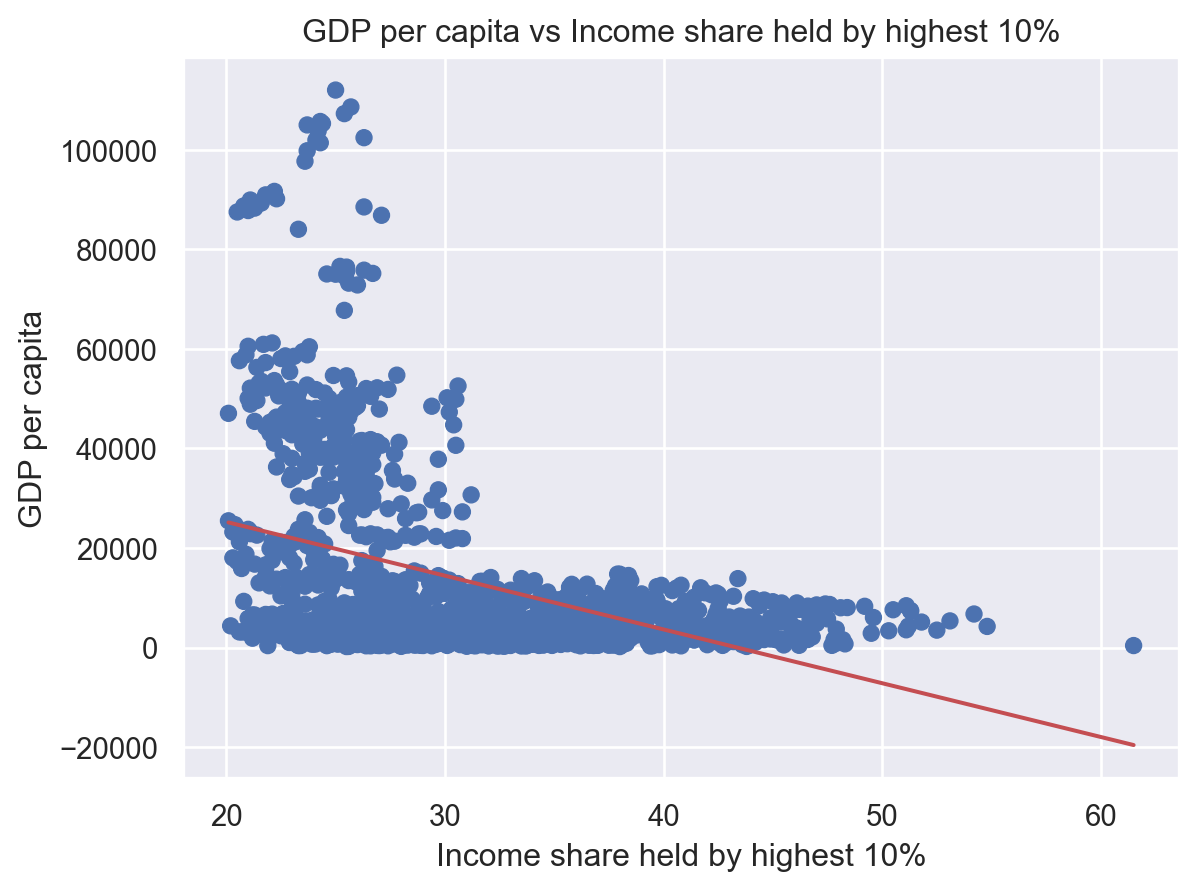

In [28]:
import seaborn.objects as so

s = so.Plot(
    data,
    x="Income share held by highest 10%",
    y="GDP per capita (constant 2010 US$)",
)
s.add(so.Dot()).add(so.Line(color="r"), so.PolyFit(1)).label(
    x="Income share held by highest 10%",
    y="GDP per capita",
    title="GDP per capita vs Income share held by highest 10%",
)

**Income inequality is negatively correlated with gdp per capita.**

In [29]:
ex7_relationship = "negatively correlated"

### Exercise 8

This analysis has allowed us to evaluate whether richer countries tend to have greater income inequality, but it certainly has not established whether we should expect that as countries become wealthier, their income distribution will also become more even. In other words, we have established a correlation between income inequality and wealth, but we certainly have not established a causal relationship between wealth and income inequality.

One way we might be able to get better traction on this question is to look at whether, as individual countries become wealthier, their income distribution also becomes more even.

To answer this question, let's begin by subsetting our data to the years 2005 to 2015 (inclusive)—the period in which the largest number of countries in our data have inequality data. Then also subset for the set of countries with Gini data for all years in this period. This gives us what's called a *balanced panel*—a dataset in which we have data on entities *at a number of different points in time* (a panel dataset) and where at every point in time, we have data for the *same set of entities* (a balanced panel dataset). 

Balanced panels are very desirable because the fact that they contain the same entities at all moments in time means that any changes we measure over time are the result of real changes in the outcomes we care about and *not* the result of changes in the composition of our sample.

Store the number of countries still in your data in `"ex8_countries_in_panel"`.

In [30]:
df_2005_2015 = data[(data["Year"] >= 2005) & (data["Year"] <= 2015)]

In [32]:
data2 = df_2005_2015["Country Name"].unique()
gini_countries = (
    df_2005_2015[["Country Name", "GINI index (World Bank estimate)"]]
    .groupby("Country Name")
    .count()
)

In [33]:
gini_countries_list = gini_countries[
    gini_countries["GINI index (World Bank estimate)"] == 11
].index.to_list()

In [34]:
gini_countries_list

['Armenia',
 'Austria',
 'Belarus',
 'Belgium',
 'Costa Rica',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Dominican Republic',
 'Ecuador',
 'El Salvador',
 'Estonia',
 'Finland',
 'France',
 'Georgia',
 'Greece',
 'Honduras',
 'Hungary',
 'Indonesia',
 'Ireland',
 'Italy',
 'Kazakhstan',
 'Kyrgyz Republic',
 'Latvia',
 'Lithuania',
 'Luxembourg',
 'Moldova',
 'Netherlands',
 'Norway',
 'Panama',
 'Paraguay',
 'Peru',
 'Poland',
 'Portugal',
 'Russian Federation',
 'Slovak Republic',
 'Slovenia',
 'Spain',
 'Sweden',
 'Turkey',
 'Ukraine',
 'United Kingdom']

In [35]:
len(gini_countries_list)

42

In [36]:
ex8_countries_in_panel = len(gini_countries_list)

### Exercise 9

Now, demean both Gini coefficient scores and log GDP per capita for all countries. In other words, for each country, calculate that country's average Gini score over this period and subtract that average from all of the country's Gini scores, then do the same for log GDP per capita. Then plot these countries' *demeaned* Gini scores against demeaned log GDP per capita.

Essentially, this is a way of looking at whether, when countries are richer than their average during this period, they have more equal income distributions than on average.

In [37]:
df_2005_2015_filtered = df_2005_2015[
    df_2005_2015["Country Name"].isin(gini_countries_list)
].reset_index(drop=True)

df_2005_2015_filtered

Indicator Name,Country Name,Year,GDP per capita (constant 2010 US$),GINI index (World Bank estimate),Income share held by fourth 20%,Income share held by highest 10%,Income share held by highest 20%,Income share held by lowest 10%,Income share held by lowest 20%,Income share held by second 20%,Income share held by third 20%,log GDP per capita
0,Armenia,2005,2571.977128,36.0,20.2,30.8,44.7,3.3,8.1,11.8,15.2,7.852430
1,Armenia,2006,2934.024882,29.7,22.1,24.5,38.8,3.7,8.9,13.1,17.0,7.984130
2,Armenia,2007,3366.664939,31.2,22.1,25.1,40.0,3.5,8.4,12.8,16.7,8.121678
3,Armenia,2008,3629.909091,29.2,22.4,23.7,38.4,3.9,9.1,13.1,17.0,8.196963
4,Armenia,2009,3137.346098,28.0,22.4,22.9,37.5,4.0,9.4,13.5,17.2,8.051133
...,...,...,...,...,...,...,...,...,...,...,...,...
457,United Kingdom,2011,39413.323879,33.2,22.8,25.3,40.7,2.9,7.4,12.2,16.8,10.581859
458,United Kingdom,2012,39706.610083,32.3,23.1,24.6,40.0,3.1,7.6,12.3,17.0,10.589273
459,United Kingdom,2013,40248.743195,33.2,23.1,25.3,40.5,2.9,7.4,12.2,16.9,10.602834
460,United Kingdom,2014,41124.121650,34.0,22.9,26.1,41.2,2.9,7.3,12.0,16.6,10.624350


In [38]:
df_2005_2015_filtered["log GDP per capita"] = np.log(
    df_2005_2015_filtered["GDP per capita (constant 2010 US$)"]
)

country_means = df_2005_2015_filtered.groupby("Country Name").mean()[
    ["GINI index (World Bank estimate)", "log GDP per capita"]
]

In [40]:
df_2005_2015_filtered = df_2005_2015_filtered.merge(
    country_means, on="Country Name", suffixes=("", "_mean")
)

In [42]:
df_2005_2015_filtered["demeaned GINI"] = (
    df_2005_2015_filtered["GINI index (World Bank estimate)"]
    - df_2005_2015_filtered["GINI index (World Bank estimate)_mean"]
)
df_2005_2015_filtered["demeaned log GDP per capita"] = (
    df_2005_2015_filtered["log GDP per capita"]
    - df_2005_2015_filtered["log GDP per capita_mean"]
)

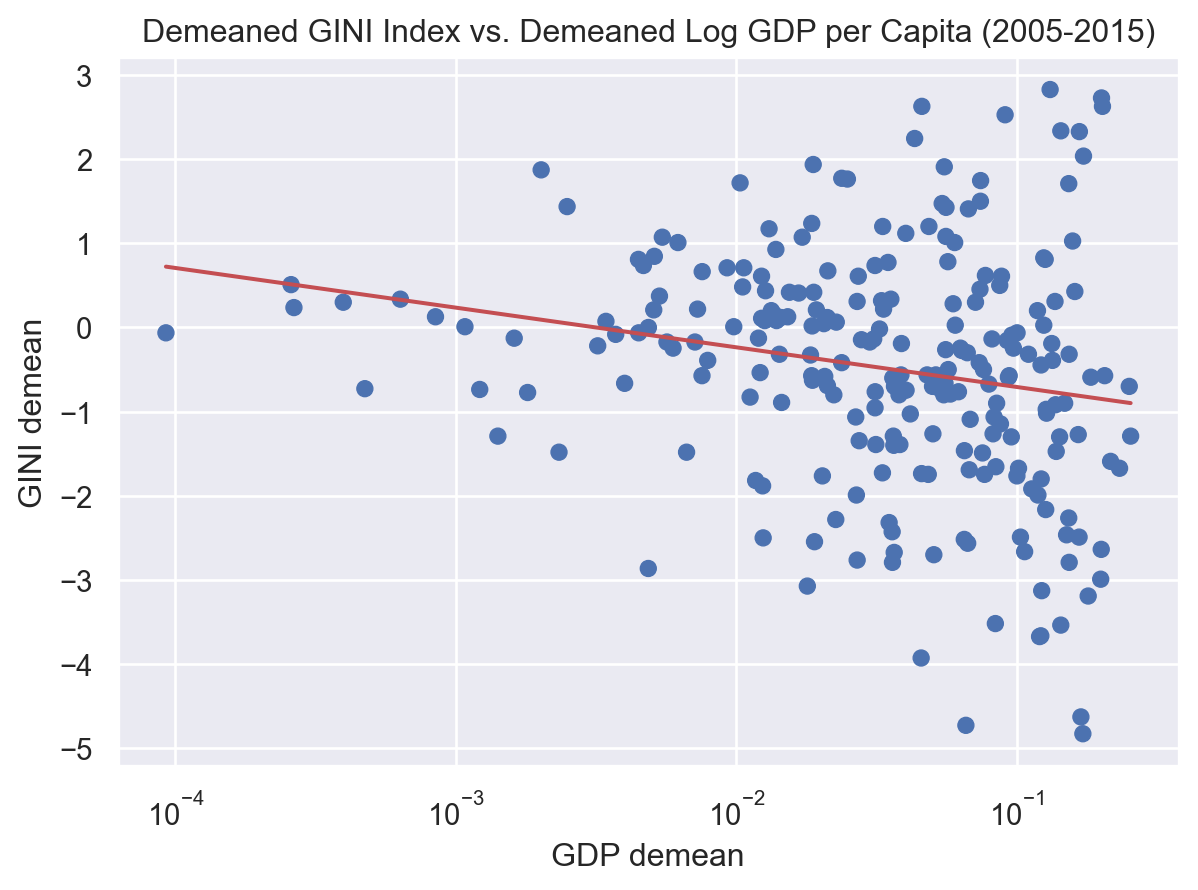

In [43]:
so.Plot(
    df_2005_2015_filtered,
    x="demeaned log GDP per capita",
    y="demeaned GINI",
).add(
    so.Dot()
).scale(x="log").add(so.Line(color="r"), so.PolyFit(1)).label(
    x="GDP demean",
    y="GINI demean",
    title="Demeaned GINI Index vs. Demeaned Log GDP per Capita (2005-2015)",
)

### Exercise 10 

Calculate the correlation between these two demand outcomes in our balanced panel and store the result in `"ex10_demeaned_corr"`.

In [44]:
ex10_demeaned_corr = df_2005_2015_filtered["demeaned GINI"].corr(
    df_2005_2015_filtered["demeaned log GDP per capita"]
)

In [45]:
results = {
    "ex2_num_rows": ex2_num_rows,
    "ex4_num_rows": ex4_num_rows,
    "ex5_num_countries": ex5_num_countries,
    "ex6_relationship": ex6_relationship,
    "ex7_relationship": ex7_relationship,
    "ex8_countries_in_panel": ex8_countries_in_panel,
    "ex10_demeaned_corr": ex10_demeaned_corr,
}

In [46]:
assert set(results.keys()) == {
    "ex2_num_rows",
    "ex4_num_rows",
    "ex5_num_countries",
    "ex6_relationship",
    "ex7_relationship",
    "ex8_countries_in_panel",
    "ex10_demeaned_corr",
}